C:\Users\Muhammad Bin Mehmood\AppData\Local\Temp\ipykernel_9028\348262360.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2015-01-01', end='2023-01-01')
[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.288574  24.757328  23.848700  24.746220  212818400
2015-01-05  23.604332  24.137513  23.417720  24.057535  257142000
2015-01-06  23.606552  23.866477  23.244433  23.668756  263188400
2015-01-07  23.937569  24.037539  23.704302  23.815381  160423600
2015-01-08  24.857304  24.915065  24.148618  24.266363  237458000


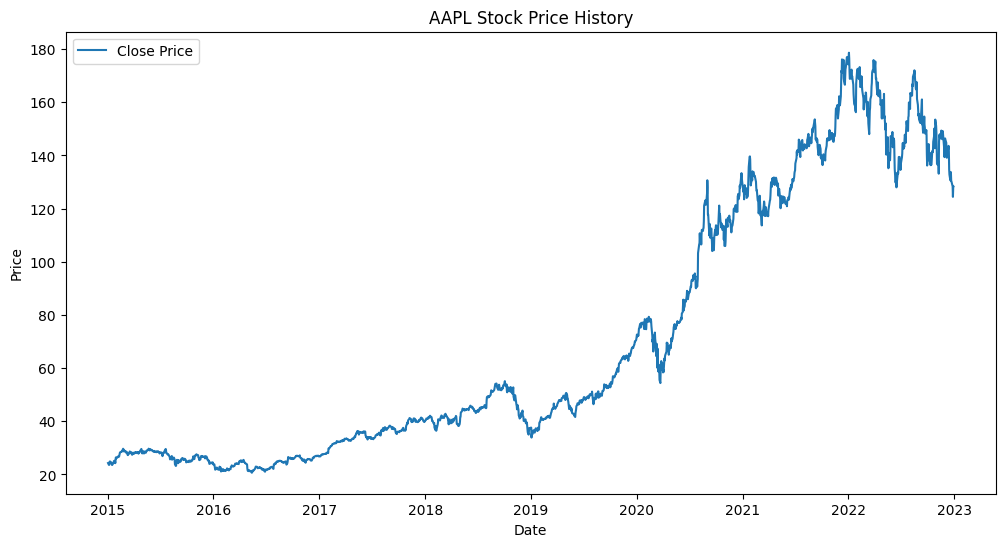

In [30]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Download stock data using yfinance
ticker = 'AAPL'  # Example: Apple stock, replace with the ticker you want
data = yf.download(ticker, start='2015-01-01', end='2023-01-01')

# Display the first few rows of the data
print(data.head())

# 2. Preprocessing
# Extract the necessary columns
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Plot the 'Close' price
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price')
plt.title(f'{ticker} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Prepare data for training (using the last 60 days to predict the next day)
def prepare_data(stock_data, time_step=60):
    X = []
    y = []
    for i in range(time_step, len(stock_data)):
        X.append(stock_data[i-time_step:i, 0])
        y.append(stock_data[i, 0])
    return np.array(X), np.array(y)

X, y = prepare_data(scaled_data)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


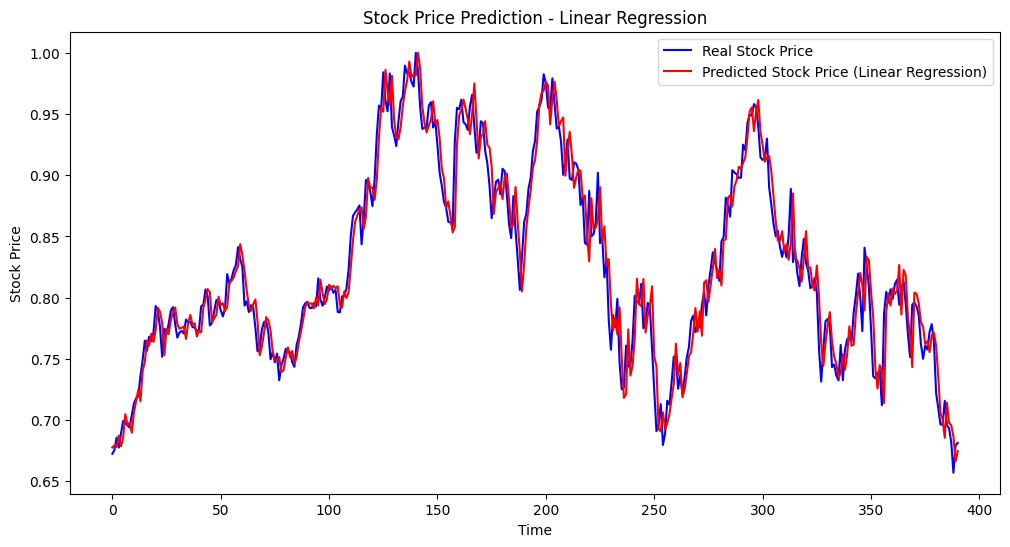

Linear Regression RMSE: 0.019537375195937304
Linear Regression R^2: 0.9388098845087965


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 3. Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)

# Predictions
lr_predictions = lr_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))

# Evaluate the model
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
lr_r2 = r2_score(y_test, lr_predictions)

# Plot the results for Linear Regression
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Real Stock Price')
plt.plot(lr_predictions, color='red', label='Predicted Stock Price (Linear Regression)')
plt.title('Stock Price Prediction - Linear Regression')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R^2: {lr_r2}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


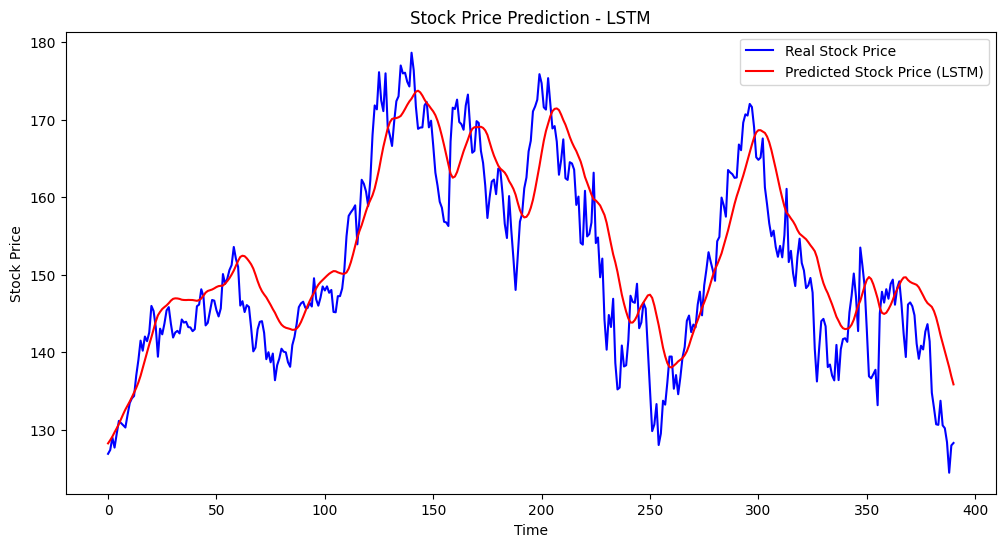

LSTM RMSE: 152.58311127396465
LSTM R^2: -3732172.0435126913


In [33]:
# Inverse transform the LSTM predictions to original scale
lstm_predictions = lstm_model.predict(X_test)

# Ensure proper reshaping for inverse scaling
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

# Evaluate the model
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_r2 = r2_score(y_test, lstm_predictions)

# Plot the results for LSTM
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Real Stock Price')  # Inverse scale y_test as well
plt.plot(lstm_predictions, color='red', label='Predicted Stock Price (LSTM)')
plt.title('Stock Price Prediction - LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM R^2: {lstm_r2}")


In [34]:
# Export the original dataset (before any transformations) to a CSV file
data.to_csv('original_stock_data.csv', index=True)


In [35]:
# Create a DataFrame with the real and predicted values
lr_results = pd.DataFrame({
    'Real Stock Price': y_test,
    'Predicted Stock Price (LR)': lr_predictions
})

# Export to CSV
lr_results.to_csv('lr_stock_predictions.csv', index=False)


In [36]:
# Create a DataFrame with the real and predicted values
lstm_results = pd.DataFrame({
    'Real Stock Price': scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(),
    'Predicted Stock Price (LSTM)': lstm_predictions.flatten()
})

# Export to CSV
lstm_results.to_csv('lstm_stock_predictions.csv', index=False)
